# The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. The orking directory has a train and test CSV file. Train has 45211 instances while test has 4521 instances

# Input variables:

# bank client data:

1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')

# related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone') 
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

# other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
import os
cwd = os.getcwd()

os.chdir("C:\\Users\\RAJA  IIT\\Desktop\\Bank Marketing")
import warnings
warnings.filterwarnings('ignore')

In [129]:
import pandas as pd
import numpy as np 
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import sklearn.feature_selection
from scipy.stats import chi2
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
plt.style.use('ggplot')

# Reading the csv train and test File

In [3]:
df=pd.read_csv('bank-full.csv', sep=None)
test=pd.read_csv('bank.csv',sep=None)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.shape,test.shape

((45211, 17), (4521, 17))

# Checking for null values for each column(train set)

In [5]:
df.replace('unknown',np.nan,inplace=True)
df.isnull().sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

In [6]:
df.replace(np.nan,'unknown',inplace=True)
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

# poutcome has about 83% of missing data, dropping the column(train and test)

In [7]:
df=df.drop('poutcome',axis=1)
test=test.drop('poutcome',axis=1)

# Exploratory Data Analysis
# Histogram wrt. Age, according to outcome(y)

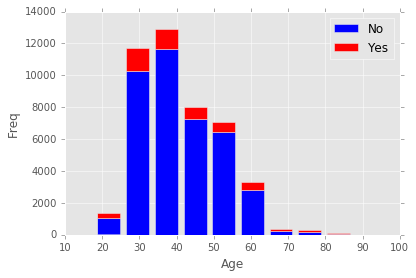

In [15]:
plt.hist([df[df['y']=='no']['age'],df[df['y']=='yes']['age']],stacked=True, color = ['b','r'],
         bins = 10,label = ['No','Yes'])
plt.xlabel('Age')
plt.ylabel('Freq')
plt.legend()

In [89]:
from sklearn.preprocessing import LabelEncoder
Encoder=LabelEncoder()
df['job_Transform']=Encoder.fit_transform(df.job)

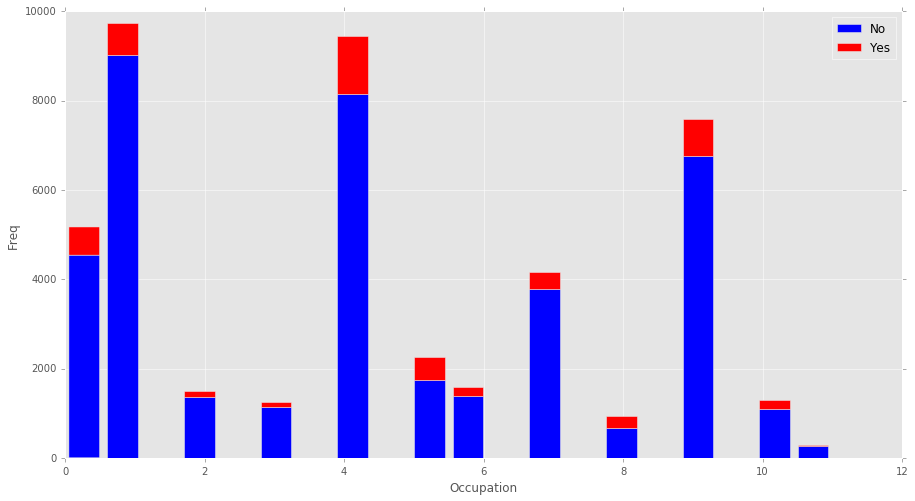

In [16]:
figure = plt.figure(figsize=(15,8))
plt.hist([df[df['y']=='no']['job_Transform'],df[df['y']=='yes']['job_Transform']],stacked=True, color = ['b','r'],
         bins = 20,label = ['No','Yes'])
plt.xlabel('Occupation')
plt.ylabel('Freq')
plt.legend()

In [12]:
df.marital.value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [13]:
df.marital_transformed=df.marital.map({'married':1,'single':2,'divorced':3})

In [39]:
A=df[df['y']=='no']['marital']
B=df[df['y']=='yes']['marital']
print('For people who declined the scheme,\n {}'.format(A.value_counts()/A.value_counts().sum()))
print('For people who accepted the scheme,\n {}'.format(B.value_counts()/B.value_counts().sum()))

For people who declined the scheme,
 married     0.612670
single      0.272481
divorced    0.114849
Name: marital, dtype: float64
For people who accepted the scheme,
 married     0.520892
single      0.361505
divorced    0.117603
Name: marital, dtype: float64


In [41]:
A=df[df['y']=='no']['education']
B=df[df['y']=='yes']['education']
print('For people who declined the scheme,\n {}'.format(A.value_counts()/A.value_counts().sum()))
print('For people who accepted the scheme,\n {}'.format(B.value_counts()/B.value_counts().sum()))

For people who declined the scheme,
 secondary    0.519814
tertiary     0.283177
primary      0.156806
unknown      0.040203
Name: education, dtype: float64
For people who accepted the scheme,
 secondary    0.463226
tertiary     0.377387
primary      0.111741
unknown      0.047646
Name: education, dtype: float64


In [42]:
A=df[df['y']=='no']['default']
B=df[df['y']=='yes']['default']
print('For people who declined the scheme,\n {}'.format(A.value_counts()/A.value_counts().sum()))
print('For people who accepted the scheme,\n {}'.format(B.value_counts()/B.value_counts().sum()))

For people who declined the scheme,
 no     0.980888
yes    0.019112
Name: default, dtype: float64
For people who accepted the scheme,
 no     0.990168
yes    0.009832
Name: default, dtype: float64


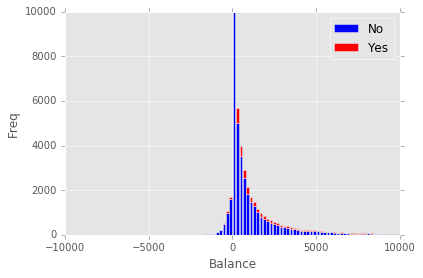

In [61]:
plt.hist([df[df['y']=='no']['balance'],df[df['y']=='yes']['balance']],stacked=True, color = ['b','r'],
         bins = 100,label = ['No','Yes'],range=(-10000, 10000))
plt.xlabel('Balance')
plt.ylabel('Freq')
plt.ylim(0,10000)
plt.legend()

In [49]:
df.balance.min()
              

-8019

In [62]:
A=df[df['y']=='no']['housing']
B=df[df['y']=='yes']['housing']
print('For people who declined the scheme,\n {}'.format(A.value_counts()/A.value_counts().sum()))
print('For people who accepted the scheme,\n {}'.format(B.value_counts()/B.value_counts().sum()))

For people who declined the scheme,
 yes    0.581008
no     0.418992
Name: housing, dtype: float64
For people who accepted the scheme,
 no     0.634146
yes    0.365854
Name: housing, dtype: float64


In [63]:
A=df[df['y']=='no']['loan']
B=df[df['y']=='yes']['loan']
print('For people who declined the scheme,\n {}'.format(A.value_counts()/A.value_counts().sum()))
print('For people who accepted the scheme,\n {}'.format(B.value_counts()/B.value_counts().sum()))

For people who declined the scheme,
 no     0.83067
yes    0.16933
Name: loan, dtype: float64
For people who accepted the scheme,
 no     0.908489
yes    0.091511
Name: loan, dtype: float64


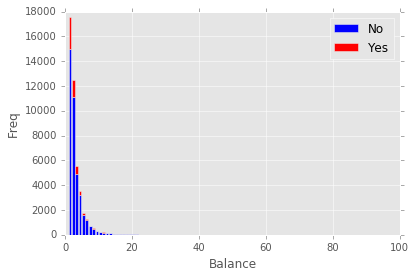

In [67]:
plt.hist([df[df['y']=='no']['campaign'],df[df['y']=='yes']['campaign']],stacked=True, color = ['b','r'],
         bins = 100,label = ['No','Yes'],range=(0, 100))
plt.xlabel('Campaign')
plt.ylabel('Freq')
plt.legend()

# Duration of a call is a strong predictor, it will also be known after the call has been made, so no way of using this as a predictor practically

In [68]:
df=df.drop('duration',axis=1)
test=test.drop('duration',axis=1)

In [90]:
df['marital_transform']=Encoder.fit_transform(df.marital)
df['education_transform']=Encoder.fit_transform(df.education)
df['default_transform']=Encoder.fit_transform(df.default)
df['housing_transform']=Encoder.fit_transform(df.housing)
df['loan_transform']=Encoder.fit_transform(df.loan)
df['y_transform']=Encoder.fit_transform(df.y)

In [84]:
df.month=df.month.map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12})

In [94]:
test.month=test.month.map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12})

In [91]:
df.corr()

,age,balance,day,month,campaign,pdays,previous,marital_transform,education_transform,default_transform,housing_transform,loan_transform,y_transform,job_Transform
age,1.000000,0.097783,-0.009120,0.092903,0.004760,-0.023758,0.001288,-0.403240,-0.106807,-0.017879,-0.185513,-0.015655,0.025155,-0.021868
balance,0.097783,1.000000,0.004503,0.094605,-0.014578,0.003435,0.016674,0.002122,0.064514,-0.066745,-0.068768,-0.084350,0.052838,0.018232
day,-0.009120,0.004503,1.000000,0.101989,0.162490,-0.093044,-0.051710,-0.005261,0.022671,0.009424,-0.027982,0.011370,-0.028348,0.022856
month,0.092903,0.094605,0.101989,1.000000,0.054868,-0.108940,-0.035600,-0.050938,0.054729,0.014989,-0.173887,0.021638,0.018717,0.043142
campaign,0.004760,-0.014578,0.162490,0.054868,1.000000,-0.088628,-0.032855,-0.008994,0.006255,0.016822,-0.023599,0.009980,-0.073172,0.006839
pdays,-0.023758,0.003435,-0.093044,-0.108940,-0.088628,1.000000,0.454820,0.019172,0.000052,-0.029979,0.124178,-0.022754,0.103621,-0.024455
previous,0.001288,0.016674,-0.051710,-0.035600,-0.032855,0.454820,1.000000,0.014973,0.017570,-0.018329,0.037076,-0.011043,0.093236,-0.000911
marital_transform,-0.403240,0.002122,-0.005261,-0.050938,-0.008994,0.019172,0.014973,1.000000,0.108576,-0.007023,-0.016096,-0.046893,0.045588,0.062045
education_transform,-0.106807,0.064514,0.022671,0.054729,0.006255,0.000052,0.017570,0.108576,1.000000,-0.010718,-0.090790,-0.048574,0.066241,0.166707
default_transform,-0.017879,-0.066745,0.009424,0.014989,0.016822,-0.029979,-0.018329,-0.007023,-0.010718,1.000000,-0.006025,0.077234,-0.022419,-0.006853


# No evident  linear relationship between columns

# Transforming Data
# Step 1- Dropping transform columns(Going to Hot-Encode later for SVM) 

In [92]:
columns=['job_Transform','marital_transform','education_transform','default_transform','housing_transform','loan_transform','y_transform']
for column in columns:
    df=df.drop(column,axis=1)

# One-Hot Encoding Test and train set

In [96]:
df.head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,5,1,-1,0,no


In [97]:
from sklearn.feature_extraction import DictVectorizer
 
def encode_onehot(df, cols):
    vec = DictVectorizer()
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(outtype='records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = df.join(vec_data)
    return df

In [98]:
X1=encode_onehot(df,cols=['job'])
X2=encode_onehot(X1,cols=['education'])
X3=encode_onehot(X2,cols=['default'])
X4=encode_onehot(X3,cols=['housing'])
X5=encode_onehot(X4,cols=['loan'])
X6=encode_onehot(X5,cols=['contact'])
X=encode_onehot(X6,cols=['marital'])

In [100]:
X1=encode_onehot(test,cols=['job'])
X2=encode_onehot(X1,cols=['education'])
X3=encode_onehot(X2,cols=['default'])
X4=encode_onehot(X3,cols=['housing'])
X5=encode_onehot(X4,cols=['loan'])
X6=encode_onehot(X5,cols=['contact'])
Xt=encode_onehot(X6,cols=['marital'])

# Separating the dependent and Independent variables

In [101]:
y=X['y']
y=y.map({'no':0,'yes':1})

In [102]:
yt=Xt['y']
yt=yt.map({'no':0,'yes':1})

In [103]:
X.drop('y',axis=1,inplace=True)
Xt.drop('y',axis=1,inplace=True)

# For fitting in feature/dimensionality reduction we standardize data, with mean=0 and variance 1

# Mapping one-hot encoding to 1,-1

In [104]:
column_keep=['job=unknown', 'job=admin.', 'job=blue-collar', 'job=entrepreneur',
       'job=housemaid', 'job=management', 'job=retired', 'job=self-employed',
       'job=services', 'job=student', 'job=technician', 'job=unemployed',
       'education=unknown', 'education=primary', 'education=secondary',
       'education=tertiary', 'default=no', 'default=yes', 'housing=no',
       'housing=yes', 'loan=no', 'loan=yes', 'contact=unknown',
       'contact=cellular', 'contact=telephone', 'marital=divorced',
       'marital=married', 'marital=single']
for column in column_keep:
    X[column]=X[column].map({0:-1,1:1})

In [105]:
column_keep=['job=unknown', 'job=admin.', 'job=blue-collar', 'job=entrepreneur',
       'job=housemaid', 'job=management', 'job=retired', 'job=self-employed',
       'job=services', 'job=student', 'job=technician', 'job=unemployed',
       'education=unknown', 'education=primary', 'education=secondary',
       'education=tertiary', 'default=no', 'default=yes', 'housing=no',
       'housing=yes', 'loan=no', 'loan=yes', 'contact=unknown',
       'contact=cellular', 'contact=telephone', 'marital=divorced',
       'marital=married', 'marital=single']
for column in column_keep:
    Xt[column]=Xt[column].map({0:-1,1:1})

# Standardizing numerical features

In [106]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler()

In [107]:
X_scaled=std_scale.fit_transform(X)
X_scaled.shape

(45211, 35)

In [108]:
Xt_scaled=std_scale.fit_transform(Xt)
Xt_scaled.shape

(4521, 35)

# Feature Selection, using PCA, we are searching for a specific n_components where variance is clearly explained by predictors

In [109]:
from sklearn.decomposition import PCA
pca = PCA(n_components=35)
X_Train=pca.fit_transform(X_scaled)

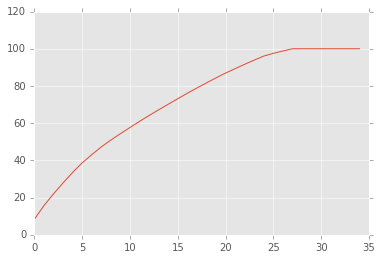

In [116]:
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var1)

# Variance explained upto 100 percent when n_comp=28, so reduce PCA back with n_comp=28

In [121]:
from sklearn.decomposition import PCA
pca = PCA(n_components=28)
X_train=pca.fit_transform(X_scaled)

In [120]:
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)

[   8.32   15.66   21.97   27.87   33.51   38.66   43.07   47.24   50.94
   54.38   57.7    60.98   64.16   67.2    70.21   73.17   76.12   78.95
   81.71   84.36   86.97   89.34   91.68   93.95   96.1    97.56   98.86
  100.03]


In [125]:
from sklearn.decomposition import PCA
pca = PCA(n_components=28)
X_test=pca.fit_transform(Xt_scaled)


In [127]:
print(X_train.shape,X_test.shape)

(45211, 28) (4521, 28)


# Data has been cleaned and scaled, no time for fitting models, starting with a logistic regression model (Model superiority on cross-val score)

In [135]:
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(C=1)
clf.fit(X_train,y)
y_pred = clf.predict(X_test)

In [136]:
from sklearn.metrics import accuracy_score
accuracy_score(yt,y_pred)

0.87878787878787878

# LogReg produces an accuracy of 87.9%, let's try SVM now

In [137]:
clf=svm.SVC(C=1)
clf.fit(X_train,y)
y_pred = clf.predict(X_test)

In [138]:
from sklearn.metrics import accuracy_score
accuracy_score(yt,y_pred)

0.88476000884760009

# We got a prediction accuracy of 88.47 a little improvement over Log Reg

In [139]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)
forest.fit(X_train,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [141]:
output = forest.predict(X_test)
accuracy_score(yt,output)

0.88144215881442156

# Not an improvement on SVM, trying AdaBoost

In [143]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
model=clf.fit(X_train,y)
y_Ada_pred = clf.predict(X_test)

In [144]:
from sklearn.metrics import accuracy_score
accuracy_score(yt,y_Ada_pred)

0.88232691882326919

# Closer to SVM than Random Forest